c:\Users\PENDO\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🌍 ENHANCED CLIMATE FORECASTING SYSTEM
This system provides comprehensive model validation and
predicts Rainfall, Vegetation Health, and Temperature
for any available country or region for the next 5 years!
✅ Data loaded and parsed successfully. Total records: 17174

📊 DATA DISTRIBUTION ANALYSIS

🌾 CROP DISTRIBUTION:
   Rice: 12238 samples (71.3%)
   Cassava: 4853 samples (28.3%)
   Maize: 83 samples (0.5%)

⚖️ Class Imbalance Ratio: 147.45:1
   ⚠️ WARNING: Significant class imbalance detected!

📈 FEATURE STATISTICS:

   RAINFALL_MM:
      Mean: 3.188, Std: 7.753
      Range: [0.000, 158.220]

   NDVI_VALUE:
      Mean: 0.482, Std: 0.176
      Range: [-0.188, 0.842]

   LST_VALUE:
      Mean: 29.749, Std: 5.535
      Range: [14.292, 47.894]

🔗 FEATURE CORRELATIONS:
             RAINFALL_MM  NDVI_VALUE  LST_VALUE
RAINFALL_MM        1.000       0.186     -0.167
NDVI_VALUE         0.186       1.000     -0.392
LST_VALUE         -0.167      -0.392      1.000


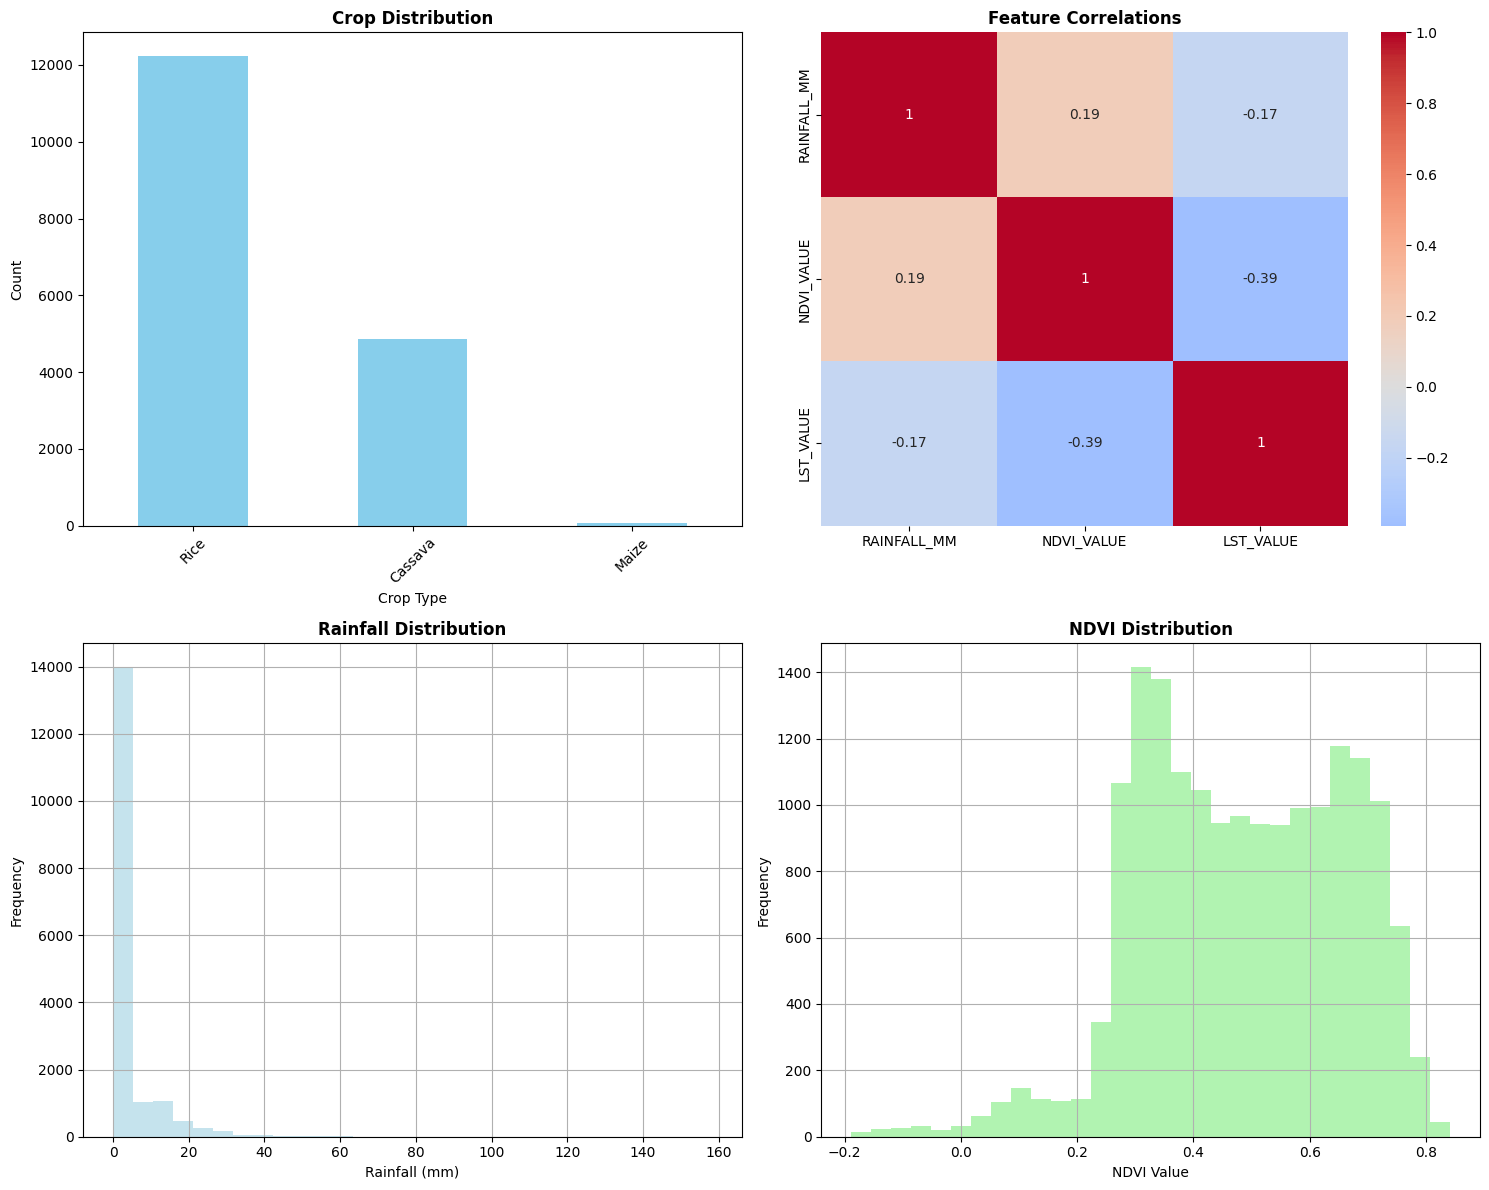


🧠 MODEL TRAINING AND VALIDATION

🔄 CROSS-VALIDATION RESULTS:
----------------------------------------
ACCURACY:
  Mean: 0.9991 (±0.0017)
  Individual folds: ['1.0000', '1.0000', '1.0000', '0.9977', '0.9988', '0.9977', '0.9988', '1.0000', '0.9988', '1.0000', '1.0000', '0.9988', '1.0000', '0.9988', '1.0000', '0.9977', '0.9988', '0.9988', '0.9988', '0.9977']
PRECISION_WEIGHTED:
  Mean: 0.9991 (±0.0017)
  Individual folds: ['1.0000', '1.0000', '1.0000', '0.9977', '0.9988', '0.9977', '0.9988', '1.0000', '0.9988', '1.0000', '1.0000', '0.9988', '1.0000', '0.9988', '1.0000', '0.9977', '0.9991', '0.9988', '0.9988', '0.9977']
RECALL_WEIGHTED:
  Mean: 0.9991 (±0.0017)
  Individual folds: ['1.0000', '1.0000', '1.0000', '0.9977', '0.9988', '0.9977', '0.9988', '1.0000', '0.9988', '1.0000', '1.0000', '0.9988', '1.0000', '0.9988', '1.0000', '0.9977', '0.9988', '0.9988', '0.9988', '0.9977']
F1_WEIGHTED:
  Mean: 0.9990 (±0.0019)
  Individual folds: ['1.0000', '1.0000', '1.0000', '0.9973', '0.9988', '0.

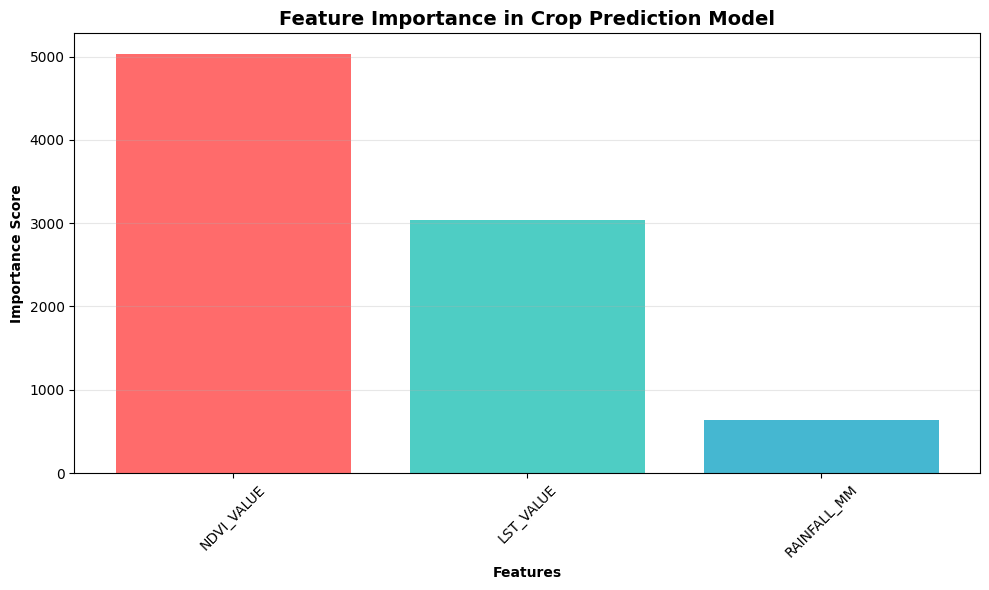


📊 CONFUSION MATRIX ANALYSIS:
----------------------------------------
Cassava: 1.0000 accuracy (971/971 correct)
Maize: 0.8750 accuracy (14/16 correct)
Rice: 0.9996 accuracy (2447/2448 correct)


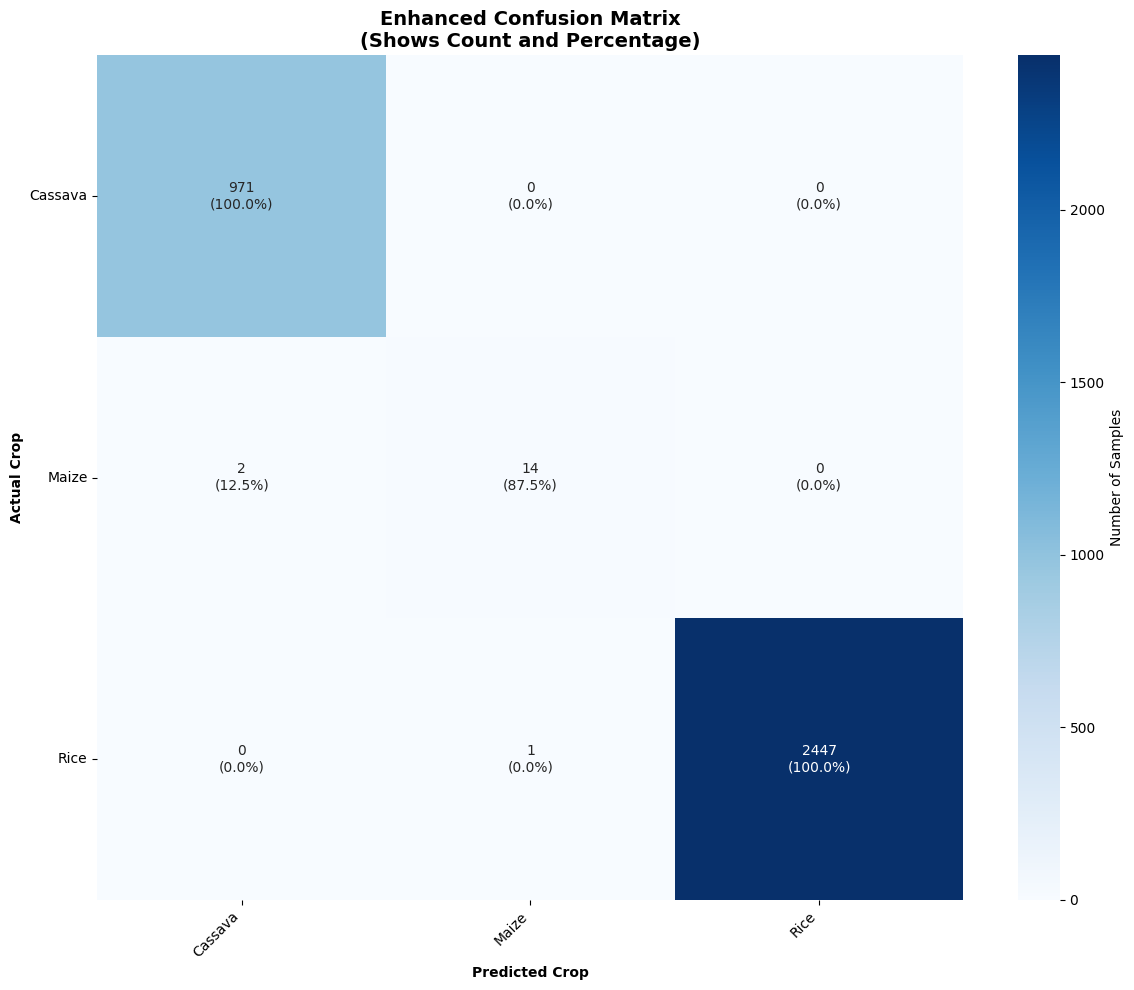


🚨 OVERFITTING ANALYSIS:
----------------------------------------
Training Accuracy: 1.0000
Test Accuracy: 0.9991
Accuracy Gap: 0.0009
✅ Good generalization (minimal overfitting)

CV Accuracy Mean: 0.9991
CV-Test Gap: 0.0001
✅ Consistent performance between CV and test set

📍 AVAILABLE REGIONS:
MWI.1.1_1: Northern Region - Chitipa
MWI.1.2_1: Northern Region - Karonga
MWI.1.3_1: Northern Region - Rumphi
MWI.2.1_1: Central Region - Kasungu
MWI.2.2_1: Central Region - Nkhotakota
MWI.2.3_1: Central Region - Ntchisi
MWI.2.4_1: Central Region - Dowa
MWI.2.5_1: Central Region - Salima
MWI.2.6_1: Central Region - Lilongwe
MWI.2.7_1: Central Region - Mchinji
MWI.2.8_1: Region MWI.2.8_1
MWI.2.9_1: Region MWI.2.9_1
MWI.3.1_1: Southern Region - Mangochi
MWI.3.2_1: Southern Region - Machinga
MWI.3.3_1: Southern Region - Zomba
MWI.3.4_1: Southern Region - Chiradzulu
MWI.3.5_1: Southern Region - Blantyre
MWI.3.6_1: Southern Region - Mwanza
MWI.3.7_1: Southern Region - Thyolo
MWI.3.8_1: Southern Regio

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score
)
import seaborn as sns
from datetime import datetime
from prophet import Prophet
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# --- Load and Prepare Data ---
def load_data(file_path):
    """
    Load and preprocess the dataset.
    """
    try:
        # Load CSV file
        combined_df = pd.read_csv(file_path)
        
        # Ensure required columns exist
        required_columns = ['GID_2', 'DATE', 'RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE', 'RECOMMENDED']
        if not all(col in combined_df.columns for col in required_columns):
            raise ValueError("Missing required columns in the dataset.")
        
        # Convert DATE column to datetime
        combined_df['DATE'] = pd.to_datetime(combined_df['DATE'], errors='coerce')
        
        # Drop rows with invalid dates or missing numerical values
        combined_df = combined_df.dropna(subset=['DATE', 'RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE', 'RECOMMENDED'])
        combined_df = combined_df.reset_index(drop=True)
        
        # Normalize crop names to title case
        combined_df['RECOMMENDED'] = combined_df['RECOMMENDED'].str.title()
        
        if combined_df.empty:
            raise ValueError("No valid data found after cleaning.")
        
        print(f"✅ Data loaded and parsed successfully. Total records: {len(combined_df)}")
        return combined_df
    except FileNotFoundError:
        print(f"❌ Error: File '{file_path}' not found. Please ensure the file is in the correct directory.")
        return None
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# --- Comprehensive Data Analysis ---
def analyze_data_distribution(combined_df):
    """
    Analyze data distribution to identify potential issues.
    """
    print("\n" + "=" * 80)
    print("📊 DATA DISTRIBUTION ANALYSIS")
    print("=" * 80)
    
    # Class distribution
    crop_counts = combined_df['RECOMMENDED'].value_counts()
    print(f"\n🌾 CROP DISTRIBUTION:")
    for crop, count in crop_counts.items():
        percentage = (count / len(combined_df)) * 100
        print(f"   {crop}: {count} samples ({percentage:.1f}%)")
    
    # Check for class imbalance
    max_class_ratio = crop_counts.max() / crop_counts.min()
    print(f"\n⚖️ Class Imbalance Ratio: {max_class_ratio:.2f}:1")
    if max_class_ratio > 10:
        print("   ⚠️ WARNING: Significant class imbalance detected!")
    
    # Feature statistics
    print(f"\n📈 FEATURE STATISTICS:")
    feature_cols = ['RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE']
    for col in feature_cols:
        stats = combined_df[col].describe()
        print(f"\n   {col}:")
        print(f"      Mean: {stats['mean']:.3f}, Std: {stats['std']:.3f}")
        print(f"      Range: [{stats['min']:.3f}, {stats['max']:.3f}]")
    
    # Correlation analysis
    correlation_matrix = combined_df[feature_cols].corr()
    print(f"\n🔗 FEATURE CORRELATIONS:")
    print(correlation_matrix.round(3))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Crop distribution
    crop_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Crop Distribution', fontweight='bold')
    axes[0,0].set_xlabel('Crop Type')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Feature correlations heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,1])
    axes[0,1].set_title('Feature Correlations', fontweight='bold')
    
    # Feature distributions
    combined_df['RAINFALL_MM'].hist(bins=30, ax=axes[1,0], color='lightblue', alpha=0.7)
    axes[1,0].set_title('Rainfall Distribution', fontweight='bold')
    axes[1,0].set_xlabel('Rainfall (mm)')
    axes[1,0].set_ylabel('Frequency')
    
    combined_df['NDVI_VALUE'].hist(bins=30, ax=axes[1,1], color='lightgreen', alpha=0.7)
    axes[1,1].set_title('NDVI Distribution', fontweight='bold')
    axes[1,1].set_xlabel('NDVI Value')
    axes[1,1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return crop_counts

# --- Enhanced Model Training with Comprehensive Validation ---
def train_and_validate_model(combined_df):
    """
    Train LightGBM model with comprehensive validation.
    """
    try:
        # Features and target
        X = combined_df[['RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE']]
        y = combined_df['RECOMMENDED']
        
        # Encode target variable
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        
        print("\n" + "=" * 80)
        print("🧠 MODEL TRAINING AND VALIDATION")
        print("=" * 80)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        
        # Train model
        model = LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbose=-1  # Suppress training output
        )
        model.fit(X_train, y_train)
        
        # === CROSS-VALIDATION ANALYSIS ===
        print("\n🔄 CROSS-VALIDATION RESULTS:")
        print("-" * 40)
        
        # Stratified K-Fold Cross Validation
        cv_folds = 20
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        # Multiple scoring metrics
        scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
        cv_results = {}
        
        for metric in scoring_metrics:
            scores = cross_val_score(model, X, y_encoded, cv=skf, scoring=metric, n_jobs=-1)
            cv_results[metric] = scores
            print(f"{metric.upper()}:")
            print(f"  Mean: {scores.mean():.4f} (±{scores.std()*2:.4f})")
            print(f"  Individual folds: {[f'{s:.4f}' for s in scores]}")
        
        # === HOLDOUT TEST SET EVALUATION ===
        print("\n🎯 HOLDOUT TEST SET RESULTS:")
        print("-" * 40)
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        # Basic metrics
        test_accuracy = accuracy_score(y_test, y_pred)
        test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='weighted', zero_division=0
        )
        
        print(f"Accuracy: {test_accuracy:.4f}")
        print(f"Precision (Weighted): {test_precision:.4f}")
        print(f"Recall (Weighted): {test_recall:.4f}")
        print(f"F1-Score (Weighted): {test_f1:.4f}")
        
        # Multi-class ROC-AUC (if more than 2 classes)
        if len(np.unique(y_encoded)) > 2:
            try:
                roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
                print(f"ROC-AUC (Weighted): {roc_auc:.4f}")
            except:
                print("ROC-AUC: Not computed (insufficient class diversity)")
        
        # === DETAILED CLASSIFICATION REPORT ===
        print("\n📋 DETAILED CLASSIFICATION REPORT:")
        print("-" * 40)
        class_names = le.inverse_transform(range(len(le.classes_)))
        report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
        
        # Display per-class metrics
        for class_name in class_names:
            if class_name in report:
                metrics = report[class_name]
                print(f"{class_name}:")
                print(f"  Precision: {metrics['precision']:.4f}")
                print(f"  Recall: {metrics['recall']:.4f}")
                print(f"  F1-Score: {metrics['f1-score']:.4f}")
                print(f"  Support: {int(metrics['support'])} samples")
        
        # === FEATURE IMPORTANCE ANALYSIS ===
        print("\n🔍 FEATURE IMPORTANCE ANALYSIS:")
        print("-" * 40)
        
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        
        print(feature_importance.to_string(index=False, float_format='%.4f'))
        
        # Feature importance visualization
        plt.figure(figsize=(10, 6))
        plt.bar(feature_importance['Feature'], feature_importance['Importance'], 
                color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        plt.title('Feature Importance in Crop Prediction Model', fontweight='bold', fontsize=14)
        plt.xlabel('Features', fontweight='bold')
        plt.ylabel('Importance Score', fontweight='bold')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # === ENHANCED CONFUSION MATRIX ===
        print("\n📊 CONFUSION MATRIX ANALYSIS:")
        print("-" * 40)
        
        # Decode predictions for confusion matrix
        y_test_decoded = le.inverse_transform(y_test)
        y_pred_decoded = le.inverse_transform(y_pred)
        unique_labels = sorted(list(set(y_test_decoded).union(set(y_pred_decoded))))
        
        cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=unique_labels)
        
        # Calculate per-class accuracy
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        for i, label in enumerate(unique_labels):
            print(f"{label}: {class_accuracies[i]:.4f} accuracy ({cm.diagonal()[i]}/{cm.sum(axis=1)[i]} correct)")
        
        # Enhanced confusion matrix visualization
        plt.figure(figsize=(12, 10))
        
        # Create annotation matrix with both counts and percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        annotations = np.array([[f'{count}\n({percent:.1f}%)' 
                               for count, percent in zip(row_counts, row_percents)]
                              for row_counts, row_percents in zip(cm, cm_percent)])
        
        sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', 
                   xticklabels=unique_labels, yticklabels=unique_labels,
                   cbar_kws={'label': 'Number of Samples'})
        plt.title('Enhanced Confusion Matrix\n(Shows Count and Percentage)', 
                 fontweight='bold', fontsize=14)
        plt.xlabel('Predicted Crop', fontweight='bold')
        plt.ylabel('Actual Crop', fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # === OVERFITTING ANALYSIS ===
        print("\n🚨 OVERFITTING ANALYSIS:")
        print("-" * 40)
        
        train_accuracy = model.score(X_train, y_train)
        accuracy_gap = train_accuracy - test_accuracy
        
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Accuracy Gap: {accuracy_gap:.4f}")
        
        if accuracy_gap > 0.05:
            print("⚠️ WARNING: Potential overfitting detected (gap > 0.05)")
        elif accuracy_gap > 0.02:
            print("⚠️ CAUTION: Mild overfitting detected (gap > 0.02)")
        else:
            print("✅ Good generalization (minimal overfitting)")
        
        # CV vs Test comparison
        cv_accuracy_mean = cv_results['accuracy'].mean()
        cv_test_gap = abs(cv_accuracy_mean - test_accuracy)
        print(f"\nCV Accuracy Mean: {cv_accuracy_mean:.4f}")
        print(f"CV-Test Gap: {cv_test_gap:.4f}")
        
        if cv_test_gap > 0.03:
            print("⚠️ WARNING: Inconsistent performance between CV and test set")
        else:
            print("✅ Consistent performance between CV and test set")
        
        return model, le, cv_results, feature_importance
        
    except Exception as e:
        print(f"❌ Error training model: {e}")
        return None, None, None, None

# --- Prophet Forecast Function ---
def prophet_forecast(series, periods):
    """
    Perform time series forecasting using Prophet.
    """
    try:
        # Prepare data for Prophet
        df = pd.DataFrame({
            'ds': series.index,
            'y': series.values
        })
        
        # Initialize and fit Prophet model
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode='multiplicative'
        )
        model.fit(df)
        
        # Create future dates
        future = model.make_future_dataframe(periods=periods, freq='D')
        forecast = model.predict(future)
        
        # Extract forecasted values
        forecast_values = forecast['yhat'].iloc[-periods:]
        forecast_dates = forecast['ds'].iloc[-periods:]
        
        # Create forecast series
        forecast_series = pd.Series(forecast_values.values, index=forecast_dates)
        
        return forecast_series, forecast, model
    except Exception as e:
        print(f"Error in Prophet forecast: {e}")
        return None, None, None

# --- Forecast Using Trained Model ---
def run_forecast_with_model(model, le, data, selection, forecast_years=5):
    """
    Run forecasting pipeline and use the trained model for crop recommendations.
    """
    try:
        # Determine time interval dynamically
        time_diff = (data.index[1] - data.index[0]).days
        periods = int(365 * forecast_years / time_diff)
        
        # Forecast Rainfall, NDVI, and Temperature using Prophet
        rainfall_forecast, _, _ = prophet_forecast(data['RAINFALL_MM'], periods)
        ndvi_forecast, _, _ = prophet_forecast(data['NDVI_VALUE'], periods)
        lst_forecast, _, _ = prophet_forecast(data['LST_VALUE'], periods)
        
        if any(x is None for x in [rainfall_forecast, ndvi_forecast, lst_forecast]):
            raise ValueError("Prophet forecasting failed for one or more variables")
        
        # Combine forecasts into a DataFrame
        forecasts = pd.DataFrame({
            'RAINFALL_MM': rainfall_forecast.values,
            'NDVI_VALUE': ndvi_forecast.values,
            'LST_VALUE': lst_forecast.values
        }, index=rainfall_forecast.index)
        
        # Predict crops using the trained model
        crop_predictions = model.predict(forecasts[['RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE']])
        crop_probabilities = model.predict_proba(forecasts[['RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE']])
        
        forecasts['PREDICTED_CROP'] = le.inverse_transform(crop_predictions)
        
        # Add prediction confidence (max probability)
        forecasts['PREDICTION_CONFIDENCE'] = crop_probabilities.max(axis=1)
        
        return forecasts
    except Exception as e:
        print(f"❌ Error during forecasting: {e}")
        return None

# --- Plot Results ---
def plot_results(historical_data, forecasts, selection):
    """
    Plot forecasting results with enhanced visualizations.
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#8B5A8C']
    
    # Rainfall plot
    axes[0,0].plot(historical_data.index, historical_data['RAINFALL_MM'],
                   label='Historical', linewidth=2, color=colors[0], alpha=0.8)
    axes[0,0].plot(forecasts.index, forecasts['RAINFALL_MM'],
                   label='Forecast', linewidth=3, color=colors[0])
    axes[0,0].set_ylabel('Rainfall (mm)', fontweight='bold')
    axes[0,0].set_title('Rainfall Forecast', fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # NDVI plot
    axes[0,1].plot(historical_data.index, historical_data['NDVI_VALUE'],
                   label='Historical', linewidth=2, color=colors[1], alpha=0.8)
    axes[0,1].plot(forecasts.index, forecasts['NDVI_VALUE'],
                   label='Forecast', linewidth=3, color=colors[1])
    axes[0,1].set_ylabel('NDVI Value', fontweight='bold')
    axes[0,1].set_title('Vegetation Health (NDVI) Forecast', fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Temperature plot
    axes[1,0].plot(historical_data.index, historical_data['LST_VALUE'],
                   label='Historical', linewidth=2, color=colors[2], alpha=0.8)
    axes[1,0].plot(forecasts.index, forecasts['LST_VALUE'],
                   label='Forecast', linewidth=3, color=colors[2])
    axes[1,0].set_ylabel('Temperature (°C)', fontweight='bold')
    axes[1,0].set_xlabel('Year', fontweight='bold')
    axes[1,0].set_title('Temperature Forecast', fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Prediction confidence plot
    axes[1,1].plot(forecasts.index, forecasts['PREDICTION_CONFIDENCE'],
                   color=colors[3], linewidth=2, marker='o', markersize=2)
    axes[1,1].set_ylabel('Prediction Confidence', fontweight='bold')
    axes[1,1].set_xlabel('Year', fontweight='bold')
    axes[1,1].set_title('Crop Prediction Confidence', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_ylim(0, 1)
    
    plt.suptitle(f'5-Year Forecast Analysis for {selection["name"]}', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# --- Main Interactive System ---
def main():
    """
    Main interactive forecasting system with enhanced validation.
    """
    print("🌍 ENHANCED CLIMATE FORECASTING SYSTEM")
    print("=" * 60)
    print("This system provides comprehensive model validation and")
    print("predicts Rainfall, Vegetation Health, and Temperature")
    print("for any available country or region for the next 5 years!")
    print("=" * 60)
    
    # Load data
    combined_df = load_data('combined_with_plants.csv')
    if combined_df is None:
        return
    
    # Analyze data distribution
    crop_counts = analyze_data_distribution(combined_df)
    
    # Train and validate model
    model, le, cv_results, feature_importance = train_and_validate_model(combined_df)
    if model is None or le is None:
        return
    
    # Get user selection
    def get_user_selection(combined_df):
        unique_gids = combined_df['GID_2'].unique()
        malawi_regions = {
            'MWI.1.1_1': 'Northern Region - Chitipa',
            'MWI.1.2_1': 'Northern Region - Karonga',
            'MWI.1.3_1': 'Northern Region - Rumphi',
            'MWI.2.1_1': 'Central Region - Kasungu',
            'MWI.2.2_1': 'Central Region - Nkhotakota',
            'MWI.2.3_1': 'Central Region - Ntchisi',
            'MWI.2.4_1': 'Central Region - Dowa',
            'MWI.2.5_1': 'Central Region - Salima',
            'MWI.2.6_1': 'Central Region - Lilongwe',
            'MWI.2.7_1': 'Central Region - Mchinji',
            'MWI.3.1_1': 'Southern Region - Mangochi',
            'MWI.3.2_1': 'Southern Region - Machinga',
            'MWI.3.3_1': 'Southern Region - Zomba',
            'MWI.3.4_1': 'Southern Region - Chiradzulu',
            'MWI.3.5_1': 'Southern Region - Blantyre',
            'MWI.3.6_1': 'Southern Region - Mwanza',
            'MWI.3.7_1': 'Southern Region - Thyolo',
            'MWI.3.8_1': 'Southern Region - Mulanje',
            'MWI.3.9_1': 'Southern Region - Phalombe',
            'MWI.4.1_1': 'Southern Region - Chikwawa',
            'MWI.4.2_1': 'Southern Region - Nsanje',
            'MWI.4.3_1': 'Southern Region - Balaka',
            'MWI.4.4_1': 'Southern Region - Neno',
        }
        region_mapping = {gid: malawi_regions.get(gid, f"Region {gid}") for gid in unique_gids}
        return region_mapping
    
    region_mapping = get_user_selection(combined_df)
    while True:
        print("\n📍 AVAILABLE REGIONS:")
        for gid, name in region_mapping.items():
            print(f"{gid}: {name}")
        user_input = input("\nEnter GID code (e.g., 'MWI.1.1_1'): ").strip()
        if user_input in region_mapping:
            selection = {'type': 'region', 'value': user_input, 'name': region_mapping[user_input]}
            break
        else:
            print("❌ Invalid selection. Please choose from the available options.")
    
    # Prepare data for forecast
    data = combined_df[combined_df['GID_2'] == selection['value']].set_index('DATE')[['RAINFALL_MM', 'NDVI_VALUE', 'LST_VALUE']]
    if data.empty:
        print(f"❌ No data found for region: {selection['value']}")
        return
    
    # Run forecast
    forecasts = run_forecast_with_model(model, le, data, selection)
    if forecasts is None:
        return
    
    # Plot results
    plot_results(data, forecasts, selection)
    
    # Enhanced summary with confidence metrics
    print("\n" + "=" * 80)
    print(f"📊 ENHANCED FORECAST SUMMARY: {selection['name']}")
    print("=" * 80)
    
    avg_rainfall = forecasts['RAINFALL_MM'].mean()
    avg_ndvi = forecasts['NDVI_VALUE'].mean()
    avg_temp = forecasts['LST_VALUE'].mean()
    avg_confidence = forecasts['PREDICTION_CONFIDENCE'].mean()
    
    print(f"\n📅 Forecast Period: {forecasts.index[0].strftime('%Y-%m-%d')} to {forecasts.index[-1].strftime('%Y-%m-%d')}")
    print(f"\n🌧  Rainfall Forecast:")
    print(f"   Average: {avg_rainfall:.1f} mm")
    print(f"   Range: {forecasts['RAINFALL_MM'].min():.1f} - {forecasts['RAINFALL_MM'].max():.1f} mm")
    print(f"\n🌿 Vegetation Health (NDVI):")
    print(f"   Average: {avg_ndvi:.3f}")
    print(f"   Range: {forecasts['NDVI_VALUE'].min():.3f} - {forecasts['NDVI_VALUE'].max():.3f}")
    print(f"\n🌡  Temperature Forecast:")
    print(f"   Average: {avg_temp:.1f}°C")
    print(f"   Range: {forecasts['LST_VALUE'].min():.1f} - {forecasts['LST_VALUE'].max():.1f}°C")
    
    print("\n" + "=" * 80)
    print(f"🌾 CROP RECOMMENDATION FOR {selection['name']}")
    print("=" * 80)
    
    recommended_crops = forecasts['PREDICTED_CROP'].value_counts()
    print(f"Most Recommended Crop: {recommended_crops.index[0]}")
    print(f"Average Prediction Confidence: {avg_confidence:.3f}")
    
    print(f"\nCrop Distribution in Forecast:")
    for crop, count in recommended_crops.items():
        percentage = (count / len(forecasts)) * 100
        print(f"   {crop}: {percentage:.1f}% of forecast period")
    
    print("=" * 80)
    
    # Model reliability summary
    print(f"\n🔍 MODEL RELIABILITY SUMMARY:")
    print(f"Cross-Validation Accuracy: {cv_results['accuracy'].mean():.4f} (±{cv_results['accuracy'].std()*2:.4f})")
    print(f"Most Important Feature: {feature_importance.iloc[0]['Feature']}")
    print("=" * 80)

# Run the enhanced system
if __name__ == "__main__":
    main()